# Three-dimensional temperature and mass profiles of galaxy clusters

We have seen in the [gas density profiles tutorial](../advanced_tutorials/cluster_gas.html) that XGA has the capacity to measure the gas density profile of a cluster, and in the [annular spectra tutorial](../advanced_tutorials/annular_spectra.html) we have seen that XGA can make (and fit models to) sets of annular spectra. That means that we can measure a projected temperature profile for a galaxy cluster

This tutorial will demonstrate how to go from a set of annular spectra to a projected temperature profile, from there to a three-dimensional temperature profile, and then how to combine that with a gas density profile to measure the hydrostatic mass of a galaxy cluster. We will detail the 'manual' way of generating a hydrostatic mass profile, and then demonstrate the convenience function that has been implemented to do the same job.

In [53]:
from xga.sources import GalaxyCluster
from xga.sourcetools.temperature import min_snr_proj_temp_prof, onion_deproj_temp_prof
from xga.sourcetools.density import ann_spectra_apec_norm
from xga.products.profile import HydrostaticMass

from astropy.units import Quantity, Unit
import numpy as np

I'm setting up a single galaxy cluster to (eventually) measure a hydrostatic mass for, though please bear in mind that the R$_{500}$, R$_{200}$, and redshift are approximate and shouldn't be used for real scientific analysis:

In [2]:
demo_src = GalaxyCluster(149.59209, -11.05972, 0.16, r500=Quantity(1200, 'kpc'), r200=Quantity(1700, 'kpc'), 
                         name="A907")

## Convenience function for creating a projected temperature profile

The [annular spectra tutorial](../advanced_tutorials/annular_spectra.html) has already shown you how to generate and fit a set of annular spectra, so we won't go through that whole process again here. Instead I will demonstrate a convenient way to go through the steps necessary to make a projected temperature profile by calling a single function `min_snr_proj_temp_prof`, for which you can find documentation [here](../../xga.sourcetools.html#xga.sourcetools.temperature.min_snr_proj_temp_prof).

This function will decide for itself how large the annuli should be, based on both a minimum signal to noise and a minimum annulus size. We also have to decide what the outer radius is going to be, and bear in mind that algorithm used to make the annuli alter the outer radius slightly so that it is an integer multiple of the minimum width, though it will never make the outer radius smaller, only larger. In this tutorial we are only using a single cluster, but this function is also compatible with a cluster sample. We're going to set `min_snr=35` (this is something you may have to experiment with), leave the minimum width set to 20 arcseconds, and generate the profile out to 1.3R$_{500}$:

In [5]:
min_snr_proj_temp_prof(demo_src, min_snr=35, outer_radii=demo_src.r500*1.3)

Generating products of type(s) spectrum: 100%|██████████| 9/9 [1:05:37<00:00, 437.50s/it] 
Generating products of type(s) annular spectrum set components: 100%|██████████| 108/108 [1:32:15<00:00, 51.25s/it] 
Running XSPEC Fits: 100%|██████████| 12/12 [05:15<00:00, 26.27s/it]


[<Quantity [  0.        ,  21.74999258,  43.49998517,  65.24997775,
             86.99997034, 108.74996292, 130.49995551, 152.24994809,
            195.74993326, 265.34990953, 330.59988729, 417.59985763,
            508.94982648] arcsec>]

## Retrieving a projected temperature profile from a source

There is a specific get method designed to retrieve *projected* temperature profiles that have been stored in a source object, `get_proj_temp_profiles`. As with most of the other get methods implemented in XGA, if you have only made one of these profiles then you can call the method with no arguments and it will be returned. Otherwise it asks you to pass the annular radii that were used to generate the profile, or the `set_id` that was assigned to the `AnnularSpectra` from which the profile was made:

In [12]:
proj_temp = demo_src.get_proj_temp_profiles()
proj_temp

## Generating profiles from a fitted `AnnularSpectra`

While we have already generated a projected temperature profile using the handy `min_snr_proj_temp_prof` function, we also wanted to demonstrate how you could manually create such a profile from a fitted `AnnularSpectra`. For this we first have to retrieve the object using the get method demonstrated in the [annular spectra tutorial](../advanced_tutorials/annular_spectra.html):

In [7]:
ann_spec = demo_src.get_annular_spectra()

Once we've read it out into a variable, we can call the `generate_profile()` [method](../../xga.products.html#xga.products.spec.AnnularSpectra.generate_profile) to tell it to assemble a profile out of a specific parameter of the fit. When it comes to temperature profiles this is rarely going to be necessary, as the temperature profile is automatically generated after the fitting process is complete, but we demonstrate this for completeness' sake:

In [9]:
manual_proj_temp = ann_spec.generate_profile('constant*tbabs*apec', 'kT', 'keV')
manual_proj_temp

## Creating a deprojected temperature profile

'Deprojection' is a process that takes us from a temperature profile that is the result of the emission of the 3D shells of a cluster being 'projected' along the line of site onto the plane that we observe with the telescope. Temperatures measured in an these annulus are a combination of the temperatures of all the 3D shells of cluster that intersect the annulus when that annulus is extended back through the cluster.

There are different methods of dealing with this, but in XGA the 'onion peeling' deprojection method has been implemented in the `onion_deproj_temp_prof()` [function](../../xga.sourcetools.html#xga.sourcetools.temperature.onion_deproj_temp_prof). The function is an implementation of a fairly old technique, though it has been used recently in [this paper](https://doi.org/10.1051/0004-6361/201731748). For a more in depth discussion of this technique and its uses I would currently recommend [this paper](https://doi.org/10.1051/0004-6361:20020905).

We need to call `onion_deproj_temp_prof()` to generate our desired deprojected profile from the projected profile we have already measured, although it is important to note that if we hadn't already made that profile then this function would have done that for us (including the generation and fitting of annular spectra). As such for a 'real-world' use case you should just call `onion_deproj_temp_prof()` and let it do everything. So now we call this function with the same arguments we used earlier, and it will automatically fetch the profile we generated, then deproject it:  

In [15]:
deproj_temp = onion_deproj_temp_prof(demo_src, min_snr=35, outer_radii=demo_src.r500*1.2)[0]

/home/dt237/code/PycharmProjects/XGA/xga/xspec/run.py:186: UserWarning: All XSPEC operations had already been run.
  warnings.warn("All XSPEC operations had already been run.")


I do not give an explanation of how this deprojection method works here, but you can find a [detailed walk-through](../advanced_tutorials/deprojected_temp_profs.html) in the 'Under the Hood' section.

## Retrieving a deprojected temperature profile from a source

The `get_3d_temp_profiles()` method of can be used to easily retrieve a deprojected temperature profile, behaving the same way as the `get_proj_temp_profiles()`: 

In [69]:
demo_src.get_3d_temp_profiles()

## Viewing the profiles

We're quickly going to look at the profiles we've just generated, using the profile view method that was introduced in the [profile tutorial](../advanced_tutorials/intro_to_profiles.html). First the original, projected, profile:

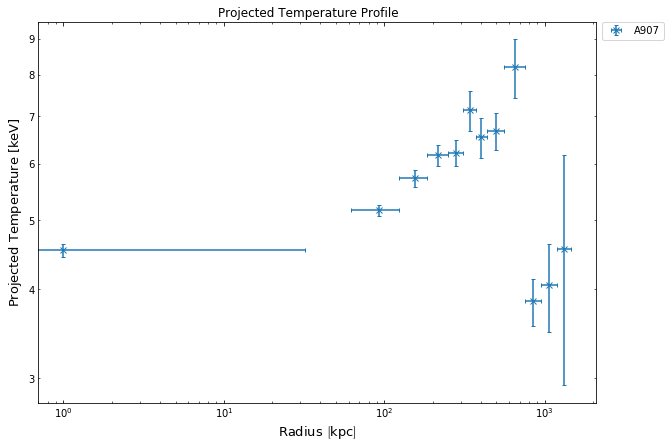

In [13]:
proj_temp.view()

Then the newly deprojected temperature profile, which will help us measure the mass of cluster:

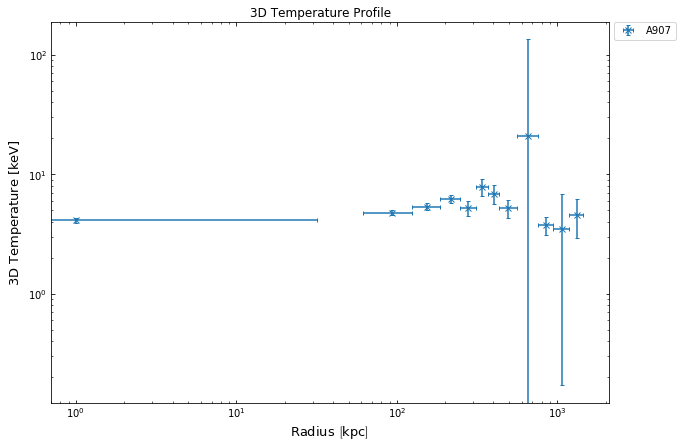

In [16]:
deproj_temp.view()

## Creating a hydrostatic mass profile

Here we will show you how to create a hydrostatic mass profile from a density and temperature profile, though we will not be explaining how hydrostatic masses work specifically as that is the subject of a another [detailed walk-through](../advanced_tutorials/how_hydro_mass_works.html) in the 'Under the Hood' section. 

We will define a mass profile manually here, but will also touch on a convenience function that can perform this whole process in a single line.

Measuring hydrostatic masses of galaxy clusters in XGA is entirely based around the `HydrostaticMass` [profile class](../../xga.products.html#xga.products.profile.HydrostaticMass), there is no way to measure a mass without one. This profile class is a special case as you do not pass the values on declaration, but pass two other profiles (deprojected temperature and three-dimensional gas density) and allow the profile class itself to do the calculation.

Speaking of which, we don't yet have the gas density profile which we need to declare the `HydrostaticMass` instance. As we've already gone to the trouble of running the generation and fitting of an `AnnularSpectra`, we're just going to run `ann_spectra_apec_norm()` (which was introduced in the [gas density profiles tutorial](../advanced_tutorials/cluster_gas.html)), with the same `min_snr` and `outer_radii` values. This will use the normalisation profile from the XSPEC model fits to measure a density profile:

In [20]:
dens_prof = ann_spectra_apec_norm(demo_src, min_snr=35, outer_radii=demo_src.r500*1.2)[0]

/home/dt237/code/PycharmProjects/XGA/xga/xspec/run.py:186: UserWarning: All XSPEC operations had already been run.
  warnings.warn("All XSPEC operations had already been run.")
Generating density profiles from annular spectra:   0%|          | 0/1 [00:00<?, ?it/s]/home/dt237/software/anaconda3/envs/XGA/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
Generating density profiles from annular spectra: 100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


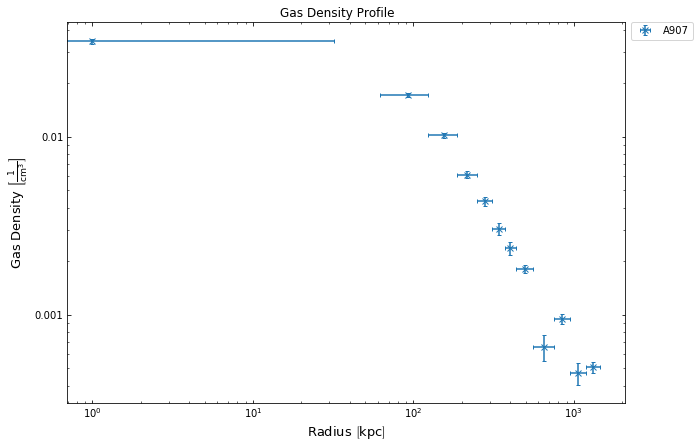

In [21]:
dens_prof.view()

The `HydrostaticMass` class requires both the input profiles to have model fits, and if they haven't been run prior to mass profile being declared then it will do it for you. As such you also have to provide the model names (or declared model instances) when you declare the mass profile. As we have not fitted a deprojected temperature profile before in these tutorials, we can quickly run the `allowed_models()` method to check what models are available:

In [22]:
deproj_temp.allowed_models('grid')

+-----------------------+------------------------------------------+------------------------------------------------+
| MODEL NAME            | EXPECTED PARAMETERS                      | DEFAULT START VALUES                           |
+=======================+==========================================+================================================+
| vikhlinin_temp        | r_cool, a_cool, t_min, t_zero, r_tran,   | 100.0 kpc, 1.0, 1.0 keV, 5.0 keV, 400.0 kpc,   |
|                       | a_power, b_power, c_power                | 1.0, 1.0, 1.0                                  |
+-----------------------+------------------------------------------+------------------------------------------------+
| simple_vikhlinin_temp | r_cool, a_cool, t_min, t_zero, r_tran,   | 100.0 kpc, 1.0, 1.0 keV, 5.0 keV, 400.0 kpc,   |
|                       | c_power                                  | 1.0                                            |
+-----------------------+-------------------------------

We're going to set `temperature_model='simple_vikhlinin_temp'` and `density_model='simple_vikhlinin_dens'`, change the `num_steps` value to 40000, and decide on which radii we should use. As the mass profile is generated from mathematics performed on continuous models, you could decide to set the radii to any values (within reason) and this would work. We, however, are going to use the radii at which the temperature values were measured with the AnnularSpectra:

In [24]:
hym_prof = HydrostaticMass(deproj_temp, 'simple_vikhlinin_temp', dens_prof, 'simple_vikhlinin_dens', 
                           deproj_temp.radii[1:], deproj_temp.radii_err[1:], deproj_temp.deg_radii[1:], 
                           num_steps=40000)

  0%|          | 82/40000 [00:00<00:48, 815.85it/s]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 800;
tau: [679.05277128 877.35527191 283.79344359 582.73071959 332.28740776
 314.82385256]


100%|██████████| 40000/40000 [00:40<00:00, 977.56it/s] 


The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 800;
tau: [1619.99998746 1167.4857135   548.97563969  646.39664684 1643.21747395
  676.54557289]


Now we can again use the `view()` method as we could with any other profile, we shall also highlight where the R$_{500}$ that was passed in at the declaration of the `GalaxyCluster` instance is:

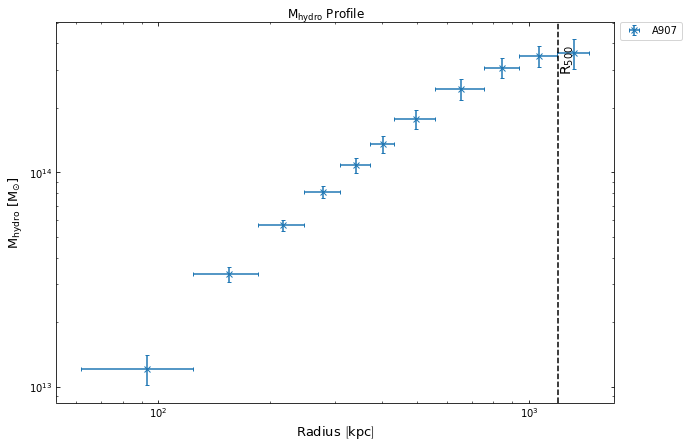

In [26]:
hym_prof.view(draw_rads={'R$_{500}$': demo_src.r500})

## Conveniently creating mass profiles with `inv_abel_dens_onion_temp()`

This function wraps various other XGA abilities and allows you to generate mass profiles for a cluster (or sample of clusters) with a single line of code. This particular convenience function uses the `onion_deproj_temp_prof()` function for the creation of the temperature profiles, and the `inv_abel_fitted_model()` function to calculate gas density from surface brightness profiles. 

We aren't making use of this in this tutorial as here we want to detail the whole process.

## Measuring a mass from a `HydrostaticMass` instance

Of course we are likely to want to measure the mass of the cluster contained within a specific radius (R$_{500}$ for instance), and of course there is a method built in to enable that, `mass()`. It works almost identically to the `gas_mass()` method built into the `GasDensity3D` class, which we showed you how to use in the [gas density profiles tutorial](../advanced_tutorials/cluster_gas.html). The only difference is that you do not need to tell the method which models were used to fit the temperature and density profiles, as the `HydrostaticMass` instance is already aware that.

The method returns a single mass value (with uncertainties calculated at `conf_level`), and a mass distribution:

In [28]:
mass_val, mass_dist = hym_prof.mass(demo_src.r500)
mass_val

<Quantity [3.59379667e+14, 4.75546298e+13, 4.58145051e+13] solMass>

In [29]:
mass_dist

<Quantity [3.49929630e+14, 4.23032356e+14, 3.57411639e+14, ...,
           3.83861515e+14, 3.85238005e+14, 3.45319976e+14] solMass>

## Viewing the mass distribution at a given radius

Again in a very similar manner to the gas density profiles, you can view a mass distribution calculated at whatever radius you would like. It takes the secondary output of `mass()` (mass_dist in the cell above) and plots it in a histogram:

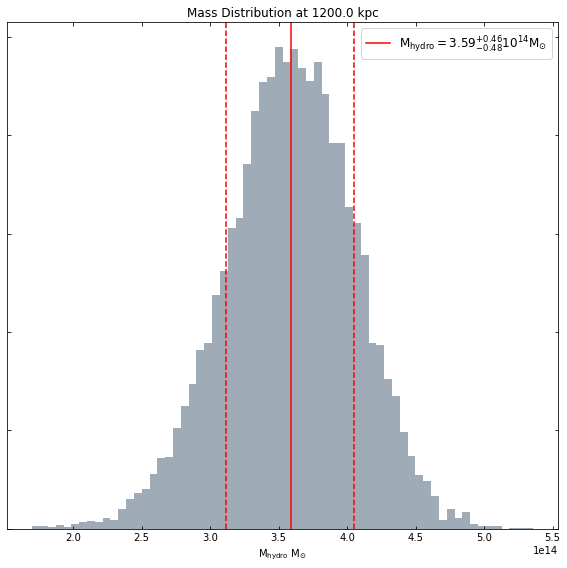

In [30]:
hym_prof.view_mass_dist(demo_src.r500)

You can request a mass within any radius you like:

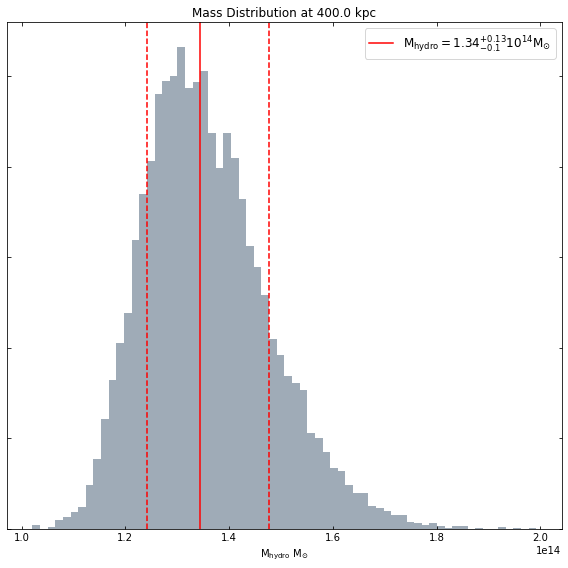

In [31]:
hym_prof.view_mass_dist(Quantity(400, 'kpc'))

## Measuring the baryon fraction within a radius

As we now have information both about the total mass of the baryons within the cluster (from the gas density profile that was fed into the `HydrostaticMass` declaration), and the total mass of the whole halo (from the calculation of the mass), we can easily calculate the [baryon fraction](https://iopscience.iop.org/article/10.1088/0004-637X/778/1/14) of the cluster within a given radius.

Simply call `baryon_fraction()`, setting the radius within which the baryon fraction should be measured, and the method will measure both the hydrostatic and gas masses within that radius, then divide the latter by the former. This method is called in the same way as `mass()` was, and returns both a single baryon fraction measurement (with uncertainty), and a baryon fraction distribution:

In [38]:
bfrac_val, bfrac_dist = hym_prof.baryon_fraction(demo_src.r500)
bfrac_val

<Quantity [0.29022388, 0.03400867, 0.04498495]>

In [39]:
bfrac_dist

<Quantity [0.29533921, 0.24746899, 0.285083  , ..., 0.27640161, 0.26916772,
           0.29860144]>

## Viewing the baryon fraction distribution within a radius

Just as we can view distributions of mass at a specific radius, we can view a baryon fraction distribution:

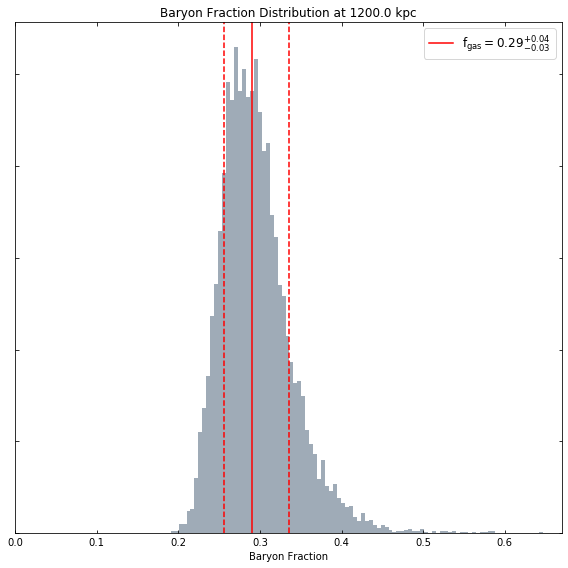

In [48]:
hym_prof.view_baryon_fraction_dist(demo_src.r500)

At whatever radius we like:

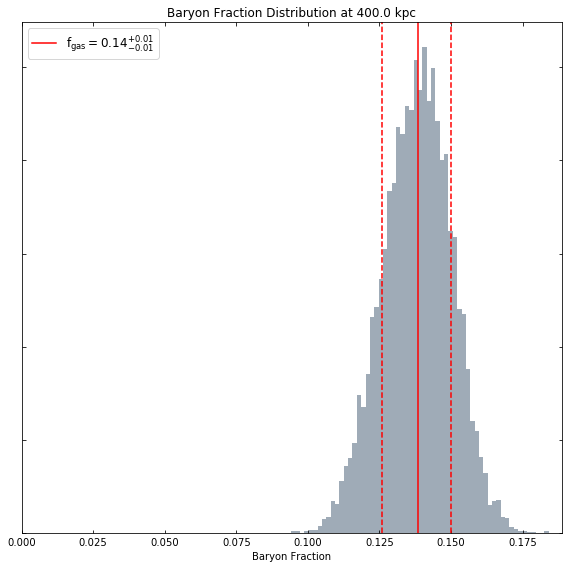

In [41]:
hym_prof.view_baryon_fraction_dist(Quantity(400, 'kpc'))

## Generating baryon fraction profiles

As I've just demonstrated, we can easily measure the baryon fraction of the cluster at different radii, and as such it is possible for a profile showing that behaviour to be constructed. A method, `baryon_fraction_profile()` has been implemented in the `HydrostaticMass` class. By default it measures baryon fraction values at the same points that the hydrostatic mass profile measures masses, but again (as the whole process is based upon continuous density and temperature models), you can use whatever radii you like:

In [50]:
bfrac_prof = hym_prof.baryon_fraction_profile()
bfrac_prof

Running the method shows us the change in baryon fraction as we move away from the centre of the cluster towards the outskirts, we also use one of the user configurable options of the `view()` method to set the y-axis scale to linear:

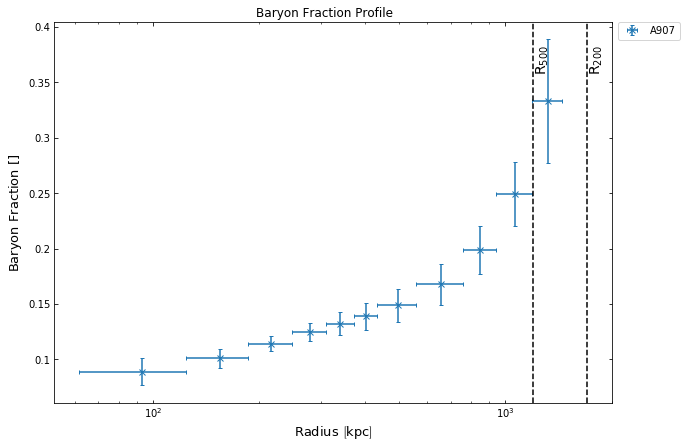

In [67]:
bfrac_prof.view(yscale='linear', draw_rads={'R$_{500}$': demo_src.r500, 'R$_{200}$': demo_src.r200})

## Retrieving a `HydrostaticMass` profile from a `GalaxyCluster`

Yet again we have implemented a handy [get method](../../xga.sources.html#xga.sources.extended.GalaxyCluster.get_hydrostatic_mass_profiles) to do this job, `get_hydrostatic_mass_profiles()`. This get method behaves in a slightly different way to others, as it wants to know which temperature and density profiles were used to generate the mass profile, along with the chosen models. It does allow you to pass no information at all however, in which case it will return every hydrostatic mass profile associated with the cluster.

As we manually made this mass profile, it hasn't actually been stored in the source at all, so if we ran the get method now we wouldn't see any results:

In [70]:
demo_src.get_hydrostatic_mass_profiles()

NoProductAvailableError: Cannot find any combined_hydrostatic_mass profiles matching your input.

This would not be the case if we had used the mass profile convenience function mentioned earlier, as that automatically stores each profile within the source it was generated for. Here we shall manually add the profile to the source object (which you can do for any product or profile you have defined manually): 

In [71]:
demo_src.update_products(hym_prof)

Now if we run the same get method again, we'll retrieve that profile:

In [72]:
demo_src.get_hydrostatic_mass_profiles()

## Other useful features of `HydrostaticMass` instances

On the whole, the `HydrostaticMass` profile behaves much like any other. Though there are a couple of useful abilities built in which are specific to this class. Just like gas density profiles have a property that allows them easily find the profile from which they were generated, the hydrostatic mass profile class has `tempererature_profile` and `density_profile` properties to easily retrieve those profiles:

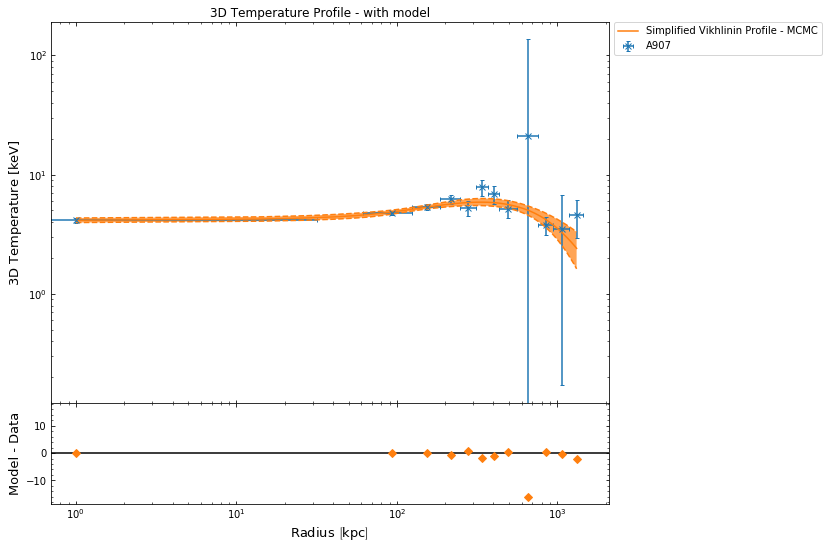

In [73]:
hym_prof.temperature_profile.view()

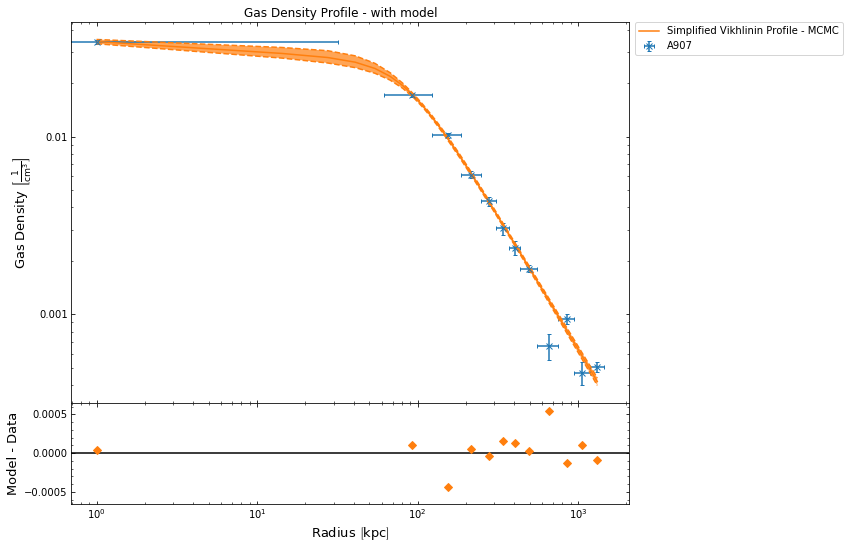

In [74]:
hym_prof.density_profile.view()

There are also equivalent properties for the fitted models, `temperature_model` and `density_model`, though they could also be accessed through the temperature and density profiles that were just retrieved:

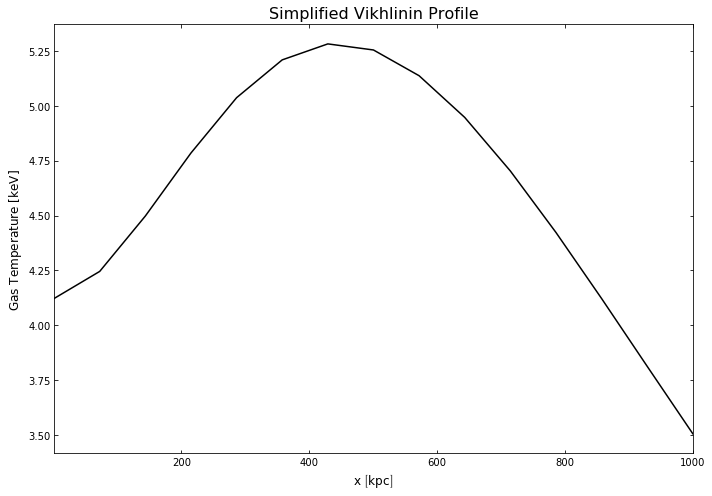

In [85]:
hym_prof.temperature_model.view(Quantity(np.linspace(1, 1000, 15), 'kpc'), xscale='linear', 
                                yscale='linear', figsize=(10, 7))

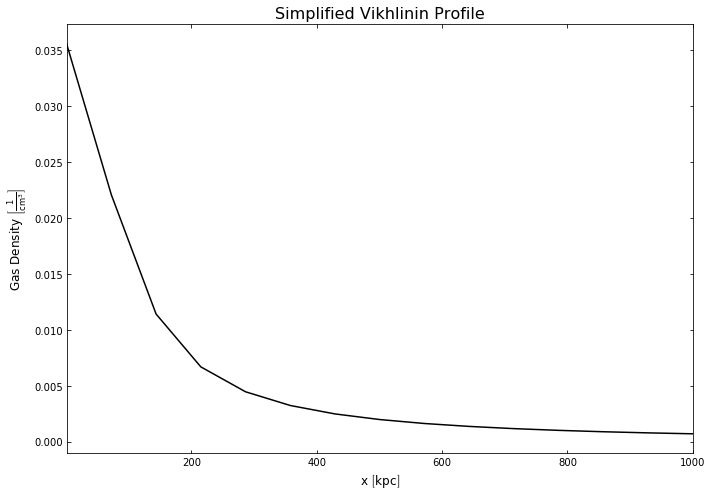

In [87]:
hym_prof.density_model.view(Quantity(np.linspace(1, 1000, 15), 'kpc'), xscale='linear', 
                            yscale='linear', figsize=(10, 7))